In [9]:
from importlib import reload
import src.evaluation.regime as regime

reload(regime)

assign_regime = regime.assign_regime
ic_by_regime = regime.ic_by_regime


In [13]:
import matplotlib.pyplot as plt


In [1]:
from src.core.pipeline import run_pipeline


In [3]:
run_pipeline


<function src.core.pipeline.run_pipeline(region: str) -> pandas.core.frame.DataFrame>

In [2]:
import numpy as np
import pandas as pd

def city_ic_by_regime(df: pd.DataFrame) -> pd.DataFrame:
    d = df[["date", "score_xs", "fwd_return"]].dropna()

    if len(d) < 24:
        return pd.DataFrame()

    d = d.copy()
    d["regime"] = np.where(d["fwd_return"] >= 0, "up", "down")

    rows = []
    for regime, g in d.groupby("regime"):
        if len(g) < 12:
            continue

        ic = g["score_xs"].corr(g["fwd_return"])

        rows.append({
            "regime": regime,
            "ic": ic,
            "positive_ratio": (g["score_xs"] * g["fwd_return"] > 0).mean(),
            "n_obs": len(g),
        })

    return pd.DataFrame(rows).set_index("regime")


In [3]:
city_ic_by_regime


<function __main__.city_ic_by_regime(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

In [5]:
from src.core.pipeline import run_pipeline

results = []

for city in ["austin", "toronto"]:
    df_city = run_pipeline(city)
    tmp = city_ic_by_regime(df_city)
    tmp["city"] = city
    results.append(tmp)

(
    pd.concat(results)
      .reset_index()
      .set_index(["city", "regime"])
)



ic  positive_ratio  n_obs
city    regime                                 
austin  down   -0.434744        0.337838     74
        up      0.075702        0.367925    106
toronto down   -0.450909        0.546296    108
        up      0.265823        0.361111     72

In [12]:
CITIES = [
    "austin",
    "toronto",
]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.core.pipeline import run_pipeline
from src.evaluation.backtest import compute_forward_return


In [2]:
# Load Toronto data
df = run_pipeline("toronto")

# Compute 12-month forward return
df = compute_forward_return(df, horizon=12)

df.head()


,region,date,price,income,population,net_migration,mortgage_rate,rent,permits,inventory,...,rent_burden,supply_pressure,migration_pressure,dti_z,pti_z,rent_burden_z,supply_pressure_z,migration_pressure_z,score_xs,fwd_return
0,toronto,2010-01-01,400000.000000,72000.000000,2.800000e+06,3000.000000,0.039589,2203.823167,2802.608272,5.980844,...,0.367304,468.597483,0.001071,1.691949,1.678900,0.895865,-0.516446,-1.327012,-1.051249,0.064050
1,toronto,2010-02-01,390154.375578,71860.695707,2.797973e+06,3890.880955,0.042489,2110.269890,2767.340268,7.934431,...,0.352393,348.776157,0.001391,1.459633,1.768445,0.088767,-1.528015,-0.348692,-1.092088,0.075966
2,toronto,2010-03-01,385717.284386,72791.816437,2.799019e+06,4325.492830,0.045246,1822.146454,2823.647732,6.206891,...,0.300388,454.921402,0.001545,1.219653,1.818487,-2.726302,-0.631904,0.125646,-0.382607,0.092301
3,toronto,2010-04-01,390053.297536,73276.715098,2.798966e+06,3907.109223,0.042323,2313.227503,2753.628832,5.644416,...,0.378821,487.850127,0.001396,1.264018,1.503188,1.519265,-0.353909,-0.332431,-1.078699,0.072754
4,toronto,2010-05-01,390001.265484,73702.007892,2.802794e+06,4205.401163,0.041558,2152.227821,2709.876725,5.474952,...,0.350421,494.958984,0.001500,1.206193,1.335210,-0.017999,-0.293894,-0.012066,-0.734938,0.093453


In [3]:
d = df.dropna(subset=["score_xs", "fwd_return"]).sort_values("date")

ts_ic = d["score_xs"].corr(d["fwd_return"])
mean_ic = ts_ic

mean_ic


np.float64(-0.1523059153834033)

In [8]:
rolling_corr = (
    d
    .set_index("date")[["score_xs", "fwd_return"]]
    .rolling(24)
    .corr()
)


rolling_ic = (
    rolling_corr
    .loc[(slice(None), "score_xs"), "fwd_return"]
    .droplevel(1)
    .dropna()
)


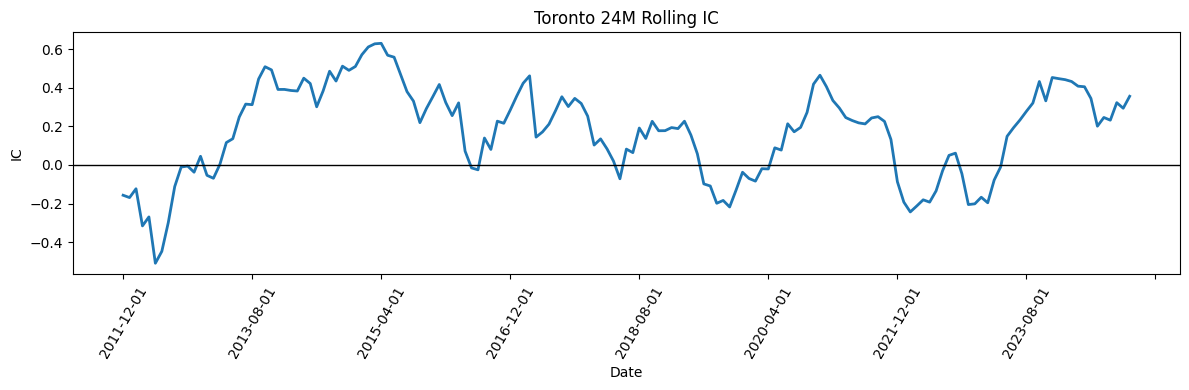

In [10]:
plt.figure(figsize=(12, 4))

rolling_ic.plot(linewidth=2)
plt.axhline(0, color="black", linewidth=1)

plt.title("Toronto 24M Rolling IC")
plt.xlabel("Date")
plt.ylabel("IC")

plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np

from src.evaluation.backtest import compute_forward_return



In [18]:
CITIES = [
    "austin",
    "toronto",
    "vancouver",
    "san_francisco",
]

In [23]:
def city_ic_stats(df):
    d = df.dropna(subset=["score_xs", "fwd_return"])

    if len(d) < 12:
        return {
            "mean_ic": np.nan,
            "std_ic": np.nan,
            "positive_ratio": np.nan,
            "n_obs": 0,
        }

    ic = d["score_xs"].corr(d["fwd_return"])

    return {
        "mean_ic": float(ic),
        "std_ic": np.nan,          # TS single number, no dispersion
        "positive_ratio": np.nan,  # not defined for TS
        "n_obs": int(len(d)),
    }

In [25]:
import pandas as pd
import numpy as np

from src.core.pipeline import run_pipeline


CITIES = [
    "austin",
    "toronto",
    "vancouver",
    "san_francisco",
]


def city_ic_stats(df: pd.DataFrame) -> dict:
    d = df[["date", "score_xs", "fwd_return"]].dropna()

    # 每个月一个 IC（cross-section = 这里退化成 time-series IC）
    ic_series = (
        d.groupby("date")[["score_xs", "fwd_return"]]
         .corr()
         .iloc[0::2, -1]
         .dropna()
    )

    return {
        "mean_ic": ic_series.mean(),
        "std_ic": ic_series.std(),
        "positive_ratio": (ic_series > 0).mean(),
        "n_obs": ic_series.count(),
    }


In [3]:
from src.core.pipeline import run_pipeline
CITIES = [
    "austin",
    "toronto",
    "vancouver",
    "san_francisco",
]


In [6]:
import numpy as np
import pandas as pd

def city_ic_stats(df: pd.DataFrame) -> dict:
    d = df[["score_xs", "fwd_return"]].dropna()

    if len(d) < 24:
        return {
            "mean_ic": np.nan,
            "std_ic": np.nan,
            "positive_ratio": np.nan,
            "n_obs": 0,
        }

    ic = d["score_xs"].corr(d["fwd_return"])

    return {
        "mean_ic": ic,
        "std_ic": np.nan,          # 单 IC，本阶段不算 std
        "positive_ratio": (d["score_xs"] * d["fwd_return"] > 0).mean(),
        "n_obs": len(d),
    }

In [7]:
rows = []

for city in CITIES:
    df_city = run_pipeline(city)
    stats = city_ic_stats(df_city)
    stats["city"] = city
    rows.append(stats)

ic_summary = (
    pd.DataFrame(rows)
      .set_index("city")
      .sort_values("mean_ic", ascending=False)
)

ic_summary


,mean_ic,std_ic,positive_ratio,n_obs
city,,,,
toronto,-0.152306,NaN,0.472222,180
austin,-0.318256,NaN,0.355556,180
vancouver,NaN,NaN,NaN,0
san_francisco,NaN,NaN,NaN,0


In [11]:
from src.core.pipeline import run_pipeline

df_van = run_pipeline("vancouver")
df_sf  = run_pipeline("san_francisco")

print("=== Vancouver ===")
print("columns:", df_van.columns.tolist())
print("NaN ratio:")
print(df_van[["score_xs", "fwd_return"]].isna().mean())
print("Non-NaN shape:")
print(df_van[["score_xs", "fwd_return"]].dropna().shape)

print("\n=== San Francisco ===")
print("columns:", df_sf.columns.tolist())
print("NaN ratio:")
print(df_sf[["score_xs", "fwd_return"]].isna().mean())
print("Non-NaN shape:")
print(df_sf[["score_xs", "fwd_return"]].dropna().shape)

=== Vancouver ===
columns: ['region', 'date', 'price', 'income', 'population', 'net_migration', 'mortgage_rate', 'rent', 'permits', 'inventory', 'dti', 'mortgage_payment', 'pti', 'rent_burden', 'supply_pressure', 'migration_pressure', 'dti_z', 'pti_z', 'rent_burden_z', 'supply_pressure_z', 'migration_pressure_z', 'score_xs', 'fwd_return']
NaN ratio:
score_xs     NaN
fwd_return   NaN
dtype: float64
Non-NaN shape:
(0, 2)

=== San Francisco ===
columns: ['region', 'date', 'price', 'income', 'population', 'net_migration', 'mortgage_rate', 'rent', 'permits', 'inventory', 'dti', 'mortgage_payment', 'pti', 'rent_burden', 'supply_pressure', 'migration_pressure', 'dti_z', 'pti_z', 'rent_burden_z', 'supply_pressure_z', 'migration_pressure_z', 'score_xs', 'fwd_return']
NaN ratio:
score_xs     NaN
fwd_return   NaN
dtype: float64
Non-NaN shape:
(0, 2)


In [17]:
import numpy as np
import pandas as pd

def city_ic_stats(df: pd.DataFrame) -> dict:
    d = df[["date", "score_xs", "fwd_return"]].dropna()

    # 没有有效样本，直接返回空
    if len(d) < 24:
        return {
            "mean_ic": np.nan,
            "std_ic": np.nan,
            "positive_ratio": np.nan,
            "n_obs": 0,
        }

    ic = d["score_xs"].corr(d["fwd_return"])

    return {
        "mean_ic": ic,
        "std_ic": np.nan,          # 单个 IC，本来就没有 std
        "positive_ratio": (d["score_xs"] * d["fwd_return"] > 0).mean(),
        "n_obs": len(d),
    }


In [18]:
CITIES = [
    "austin",
    "toronto",
    "vancouver",
    "san_francisco",
]

rows = []

for city in CITIES:
    df_city = run_pipeline(city)
    stats = city_ic_stats(df_city)
    stats["city"] = city
    rows.append(stats)

ic_summary = (
    pd.DataFrame(rows)
      .set_index("city")
      .sort_values("mean_ic", ascending=False)
)

ic_summary


,mean_ic,std_ic,positive_ratio,n_obs
city,,,,
toronto,-0.152306,NaN,0.472222,180
austin,-0.318256,NaN,0.355556,180
vancouver,NaN,NaN,NaN,0
san_francisco,NaN,NaN,NaN,0


In [19]:
import numpy as np
import pandas as pd

def city_ic_by_regime(df: pd.DataFrame) -> pd.DataFrame:
    d = df[["date", "score_xs", "fwd_return"]].dropna()

    if len(d) < 24:
        return pd.DataFrame()

    d = d.copy()
    d["regime"] = np.where(d["fwd_return"] >= 0, "up", "down")

    rows = []
    for regime, g in d.groupby("regime"):
        if len(g) < 12:
            continue

        ic = g["score_xs"].corr(g["fwd_return"])

        rows.append({
            "regime": regime,
            "ic": ic,
            "positive_ratio": (g["score_xs"] * g["fwd_return"] > 0).mean(),
            "n_obs": len(g),
        })

    return pd.DataFrame(rows).set_index("regime")


In [20]:
df_austin = run_pipeline("austin")
city_ic_by_regime(df_austin)


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,0.075702,0.367925,106


In [21]:
df_toronto = run_pipeline("toronto")
city_ic_by_regime(df_toronto)


,ic,positive_ratio,n_obs
regime,,,
down,-0.450909,0.546296,108
up,0.265823,0.361111,72


In [6]:
from src.core.pipeline import run_pipeline
from src.evaluation.regime import assign_regime

df = run_pipeline("austin")
df = assign_regime(df)

df[["date", "score_xs", "fwd_return", "regime"]].dropna().head()


,date,score_xs,fwd_return,regime
0,2010-01-01,-0.911447,0.005912,up
1,2010-02-01,-0.545640,0.023938,up
2,2010-03-01,-1.145638,0.020693,up
3,2010-04-01,-1.237509,-0.000921,down
4,2010-05-01,-0.405309,-0.002548,down


In [10]:
from src.core.pipeline import run_pipeline
import pandas as pd

CITIES = ["austin", "toronto"]

rows = []

for city in CITIES:
    df = run_pipeline(city)
    df = assign_regime(df)

    stats = ic_by_regime(df, signal_col="score_xs")
    stats["city"] = city
    rows.append(stats)

summary = (
    pd.concat(rows)
      .reset_index()
      .set_index(["city", "regime"])
)

summary


ic  positive_ratio  n_obs
city    regime                                 
austin  down   -0.434744        0.337838     74
        up      0.075702        0.367925    106
toronto down   -0.450909        0.546296    108
        up      0.265823        0.361111     72

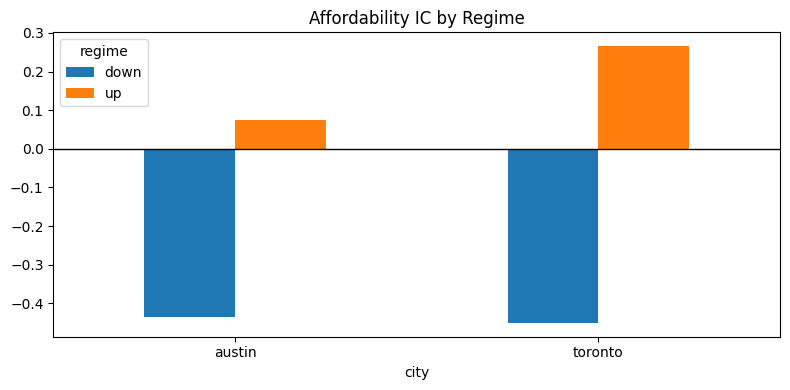

In [14]:
import matplotlib.pyplot as plt

summary.reset_index().pivot(
    index="city",
    columns="regime",
    values="ic"
).plot(
    kind="bar",
    figsize=(8, 4),
    title="Affordability IC by Regime",
    rot=0
)

plt.axhline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


Key finding:
Affordability exhibits strong negative IC during down regimes across cities,
indicating its role as a pro-cyclical risk factor.
In up regimes, the signal weakens or becomes unstable.
